# Project: 

_Course: 02805 - **Social Graphs and Interactions**_ <br>
_Course responsible: **Sune Lehmann Jørgensen**_ <br>
_DTU - **Technical University of Denmark**_

---

## Table of Contents:

- [__Part 1: Background__](#1.)
    
    - [1.1. <u>Motivation</u>](#1.1.)
    - [1.2. <u>Information of dataset</u>](#1.2.)
    

- [__Part 2: NLP Analysis of Business__](#2.)

- [__Part 3: Network Analysis__](#3.)

    - [3.1. <u></u>](#1.1.)
    - [3.2. <u>Community detection</u>](#1.2.)
    - [3.3. <u>Community wordclouds</u>](#1.2.)


- [__Part 4: Sentiment Analysis__](#4.)

---

### Import

In [ ]:
# Basic libraries
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
import itertools

In [ ]:
# Network libraries
import networkx as nx
from fa2 import ForceAtlas2 as FA2
import community

In [ ]:
# NLP libraries
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator

In [588]:
# Display libraries
from IPython.display import display
from IPython.core.display import display as disp, HTML
from ipywidgets import widgets, interact, interactive, fixed, interact_manual
import imageio

from plotly import __version__
import plotly.io as pio
import plotly.express as px
import plotly.figure_factory as ff
import chart_studio.plotly as py
import plotly.offline
sns.set()

In [550]:
pio.renderers.default = 'notebook'

---
<a id='1.'></a>
## Part 1: Background

<a id='1.1.'></a>
### 1.1 Motivation:

__Yelp__ is a websites as well as application, who provides a platform for users to publish reviews and rateings of local businesses. As a site with over 102 million reviews and counting, we believe there is a network connecting each business solely by reviews from their customers. Therefore, our main goal of this project is:  

<a id='1.2.'></a>
### 1.2 Information of dataset

Load filtered data:

In [3]:
business_df = pd.read_csv('./yelp_dataset/las_vegas_business.csv')
review_df = pd.read_csv('./yelp_dataset/las_vegas_review.csv')
user_df = pd.read_csv('./yelp_dataset/las_vegas_user.csv')

/Users/yingrui/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Filter data further according to certain category (Hotel in this case):

In [589]:
# Filter business_id according to the category
filter_business_id = business_df[business_df.categories.str.contains(r"(Hotels, )|(, Hotels$)", regex = True)==True].business_id

/Users/yingrui/opt/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



In [5]:
# Filter businesses
business_df = business_df[business_df.business_id.isin(filter_business_id)].reset_index().drop('index', axis = 1)
                                                                                                        .rename({'stars': 'stars_business'})

In [6]:
# Filter reviews based on business_id
review_df = review_df[review_df.business_id.isin(filter_business_id)].reset_index().drop('index', axis = 1)
                                                                                              .rename({'stars': 'stars_review'})

---
<a id='2.'></a>
## Part 2: NLP Anlysis of Business

* Join review and business data frames:

In [9]:
business_review_df = pd.merge(business_df, review_df, on='business_id', how='outer')

In [10]:
business_review_df.head(1)

business_id                        name                address  \
0  izw7OBVSeNmlVhjly1amQg  Wyndham Vacation Ownership  3475 Las Vegas Blvd S   

        city state  postal_code   latitude   longitude  stars_x  review_count  \
0  Las Vegas    NV      89109.0  36.119725 -115.172396      1.5           154   

   ...                                         categories hours  \
0  ...  Hotels & Travel, Hotels, Event Planning & Serv...   NaN   

                review_id                 user_id stars_y useful  funny  cool  \
0  h4mPmRnFUgekEvtbvXMeWw  ANGEDyzIN7xlEOdxe5U5Wg     1.0    0.0    0.0   0.0   

                                                text                 date  
0  Went to the presentation and spent 4 hours the...  2018-06-19 18:13:32  

[1 rows x 22 columns]

* Extract words which are adjectives since it would be the most informative type in reviews:

In [11]:
# Function to test if something is an adjective
is_adj = (lambda pos: pos[:2] == 'JJ')

In [12]:
# Function for tokenizing the text into a list of words
def tokenize_text(text):
    # Replace all the non-alphanumeric characters with space
    text = re.sub(r'[\W]', ' ', text)

    # Tokenize texts into lists of tokens
    words = word_tokenize(text)    
   
    stop_words = set(stopwords.words('english'))
       
    words = [word.lower() for word in words if word not in string.punctuation]    # Remove punctuation and set words to lowercase
    words = [word for word in words
                 if word not in stop_words
                 if len(word) > 1]    # Remove stopwords and letters (stopwords are lowercase, so this step should be done after word.lower())
    words = [word for (word, pos) in nltk.pos_tag(words) if is_adj(pos)]    # Keep adjectives only

    return words

* Combine reviews in each business or each community into one text according to different cases:

In [13]:
def reviews(df, mode, dict_communities = None):
    
    if mode == 'community':
        # Create a dictionary for storing text of each community
        community_reviews = {}
        for comm in dict_communities.keys():
            community_text = ' '
            for business_id in dict_communities[comm]:
                business_text = ' '.join(df[df.business_id==business_id].text)
                community_text += business_text
            community_reviews[comm] = community_text
        return community_reviews
      
    if mode == 'business':
        # Within each business
        business_reviews = {}
        for business_id in df.business_id.unique():      
            # Concatenate all reviews of a specific business into one text
            business_text = ' '.join(df[df.business_id==business_id].text)
            business_reviews[business_id]  = business_text
        return business_reviews

* Compute TF-IDF scores to extract key words of each business or community:

>  Function for computint TF score

In [14]:
# Function for computing TF (using different methods)
def tf(reviews, tf_method = 'term_frequency'):

    # Create a nested dictionary {business: {word: tf score}} or {business: {word: tf score}} for storing term-frequency
    term_frequency = {}

    for comm, review in reviews.items():
        # Create a dictionary for each either community or business to store words and counts of words
        term_frequency[comm] = {}

        # Total word amount for one business (for tf_method=='term_frequency')
        total_word_amount = len(review)
        # Tokenize the text into a list of words
        words = tokenize_text(review)
        # Count words
        for word in words:
            if word not in term_frequency[comm].keys():
                term_frequency[comm][word] = 1
            else:
                term_frequency[comm][word] += 1       

        # Compute different types of term frequency
        if tf_method == 'raw_count':
            term_frequency = term_frequency

        elif tf_method == 'term_frequency':
            term_frequency[comm] = {k : v/total_word_amount for k, v in term_frequency[comm].items()}

        elif tf_method == 'log':
            term_frequency[comm] = {k : math.log(1 + v) for k, v in term_frequency[comm].items()}

        elif tf_method == 'double_normalization':
            term_frequency[comm] = {k : (0.5 + 0.5*v/max(term_frequency[comm].values())) for k, v in term_frequency[comm].items()}        

    return term_frequency

> Function for computing IDF score

In [15]:
# Function for computing IDF (using different methods)
def idf(reviews, term_frequency, idf_method='idf'):
    # Total number of documents (i.e. total number of businesses in this case, because we concatenate all the reviews of one specific business)
    N = len(reviews.keys())
    
    # Create a nested dictionary for {business: {word: idf score}} storing term-frequency
    inverse_document_frequency = {}
    
    for comm1 in term_frequency.keys():
        # Update the idf dictionary into form as {business: {word: 0}}
        inverse_document_frequency[comm1] = {k : 0 for k in term_frequency[comm1].keys()}
        
        for word in term_frequency[comm1]:
            # If a specific word occurs in another business, add 1 to the count of this word
            for comm2 in term_frequency.keys():
                if word in term_frequency[comm2].keys():
                    inverse_document_frequency[comm1][word] += 1
        
        # Compute different types of inverse document frequency based on the number of occurance of a word in all the businesses
        if idf_method == 'idf':
            inverse_document_frequency[comm1] = {k : math.log(N/v) for k, v in inverse_document_frequency[comm1].items()}
        elif idf_method == 'idf_smooth':
            inverse_document_frequency[comm1] = {k : (math.log(N/(1+v))+1) for k, v in inverse_document_frequency[comm1].items()}
    
    
    return inverse_document_frequency

> Function for computing TF-IDF score

In [18]:
# Function for computing TD-IDF score
def tf_idf(term_frequency, inverse_document_frequency):
    
    tf_idf = {}
    for comm in term_frequency:
        tf_idf[comm] = {k : v*term_frequency[comm][k] for k, v in inverse_document_frequency[comm].items()}
    
    return tf_idf

* Calculate TF, IDF, TF-IDF score of each business:

In [20]:
# Convert reviews of each business into one text for analysis
business_reviews = reviews(df = business_review_df, mode = 'business')

In [21]:
# Calculate term frequency of each business
business_term_frequency = tf(reviews = business_reviews, tf_method = 'term_frequency')

In [22]:
# Calculate inverse document frequency of each business
business_inverse_document_frequency  =  idf(reviews = business_reviews, term_frequency = business_term_frequency, idf_method = 'idf')

In [23]:
# Calculate TF-IDF score of each business
business_tf_idf = tf_idf(term_frequency = business_term_frequency,  inverse_document_frequency = business_inverse_document_frequency)

* Extract key words of each business

In [568]:
# Function for extracting top keywords with highest TF-IDF score of each business
def retrieve_top_n_keywords(n, tf_idf_score = business_tf_idf):
    
    # Create a dictionary, which will contain top n keywords for each business
    top_keywords_dict = {}
    
    # For each business, we will save its business_id and its top n keywords in a dictionary
    for business_id, term_dict in tf_idf_score.items():
        
        # Sort the terms by their TF-IDF score (descendingly), and keep the top n keywords
        top_n_keywords_list = [tf_idf_tuple[0] for tf_idf_tuple in sorted(term_dict.items(), key = (lambda x : x[1]), reverse = True)][0:n]
        top_keywords_dict[business_id] = list(top_n_keywords_list)
        
    return top_keywords_dict

In [569]:
# n = how many top keywords should the network check for nodes to have in common
n = 5
business_top_keywords = retrieve_top_n_keywords(n)

In [570]:
# Add a column containing top keywords of each business to the original dataframe
business_df['top_keywords'] = business_df['business_id'].map(business_top_keywords)

In [571]:
business_df.head(1)

business_id                        name                address  \
0  izw7OBVSeNmlVhjly1amQg  Wyndham Vacation Ownership  3475 Las Vegas Blvd S   

        city state  postal_code   latitude   longitude  stars  review_count  \
0  Las Vegas    NV      89109.0  36.119725 -115.172396    1.5           154   

   ...  sentiment_Q2 sentiment_Q4 sentiment_Q1 sentiment_Q3 sentiment_Night  \
0  ...         0.049        0.325        0.216         0.03           0.262   

   sentiment_Morning  sentiment_Midnight  sentiment_Noon  sentiment_Afternoon  \
0              0.009               0.126          -0.022                0.157   

   sentiment  
0      0.163  

[1 rows x 25 columns]

In [168]:
# business_df.to_csv('./yelp_dataset/las_vegas_business_keywords.csv')

---
<a id='3.'></a>
## Part 3: Network Analysis

* Create network

Already now, we can create a network graph, and initialize a node for every unique business_id:

In [582]:
G = nx.Graph()

# Adding nodes
G.add_nodes_from(business_top_keywords.keys())

print('Initially, the total number of nodes/businesses in the network is:', G.number_of_nodes())

Initially, the total number of nodes/businesses in the network is: 421


In [514]:
# We will remodel the "Top Keywords" dictionary into a dataframe in long-format, where each row corresponds to a (business_id, unique_keyword) combination
# We want this specific form for the dataframe, so that we can group by keywords afterwards, and identify which businesses have keywords in common
# A .reset_index() is needed here, in order to add an dummy extra column for the "groupby" function to perform a "count" operation into.

keyword_df = pd.DataFrame(top_keywords_dict).melt(var_name = 'business_id', value_name = 'keywords').reset_index()

In [515]:
# Group keywords by 'business_id', to find the businesses sharing top keywords

grouped_keyword_df = keyword_df.groupby(['keywords', 'business_id']).count()['index']

In [516]:
# Here, we are interating through the grouped set of keywords, 
# and if two businesses have the same keyword in common, we will create a network edge between the two busineses

for _, business_sub_df in grouped_keyword_df.groupby(level = 0):
    
    # This is a list of combinations of 2 businesses which have the same top keyword in common
    edges_list = list(itertools.combinations(business_sub_df.droplevel(0).index, 2))
    
    for node1, node2 in edges_list:
        
        if G.has_edge(node1, node2):
            # we added this connection before, just increase the weight by one
            G[node1][node2]['weight'] += 1
            
        else:
            # new edge, therefore initialize link with weight = 1
            G.add_edge(node1, node2, weight = 1)

In [517]:
print('Using the top n = %d keywords from TF-IDF, the initialized number of edges is: %d' % (n, G.number_of_edges()))

Using the top n = 10 keywords from TF-IDF, the initialized number of edges is: 10791


In [518]:
# Remove the isolated nodes from the graph
G.remove_nodes_from(list(nx.isolates(G)))

# Remove nodes outside the main connected component (i.e. outside the GCC)
for component in list(nx.connected_components(G.to_undirected())):
    if (len(component) < 5):
        for node in component:
            G.remove_node(node)

print('After removal of isolated or non-GCC nodes, the total number of nodes/businesses in the network is:', G.number_of_nodes())
print('Also, the number of edges present in the network now is:', G.number_of_edges())

After removal of isolated or non-GCC nodes, the total number of nodes/businesses in the network is: 421
Also, the number of edges present in the network now is: 10790


---

### Plotting of network graph:

In [33]:
# Create instance for FA2
forceatlas2 = FA2(scalingRatio = 100, gravity = 100, outboundAttractionDistribution = True)

# Calculate positions of nodes in the visualization
positions = forceatlas2.forceatlas2_networkx_layout(G, pos = None, iterations = 1000)

100%|██████████| 1000/1000 [00:03<00:00, 312.32it/s]

BarnesHut Approximation  took  0.87  seconds
Repulsion forces  took  1.88  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.16  seconds
AdjustSpeedAndApplyForces step  took  0.11  seconds


In [34]:
node_sizes = []

for node in G:
    
    total_reviews = business_df[business_df.business_id == node].review_count
    
    # Append the appropriate size to a node
    node_sizes.append(total_reviews * 0.025)

In [35]:
labels = nx.get_edge_attributes(G,'weight')
print(list(set(labels.values())))

[1, 2, 3, 4, 5, 6, 7]


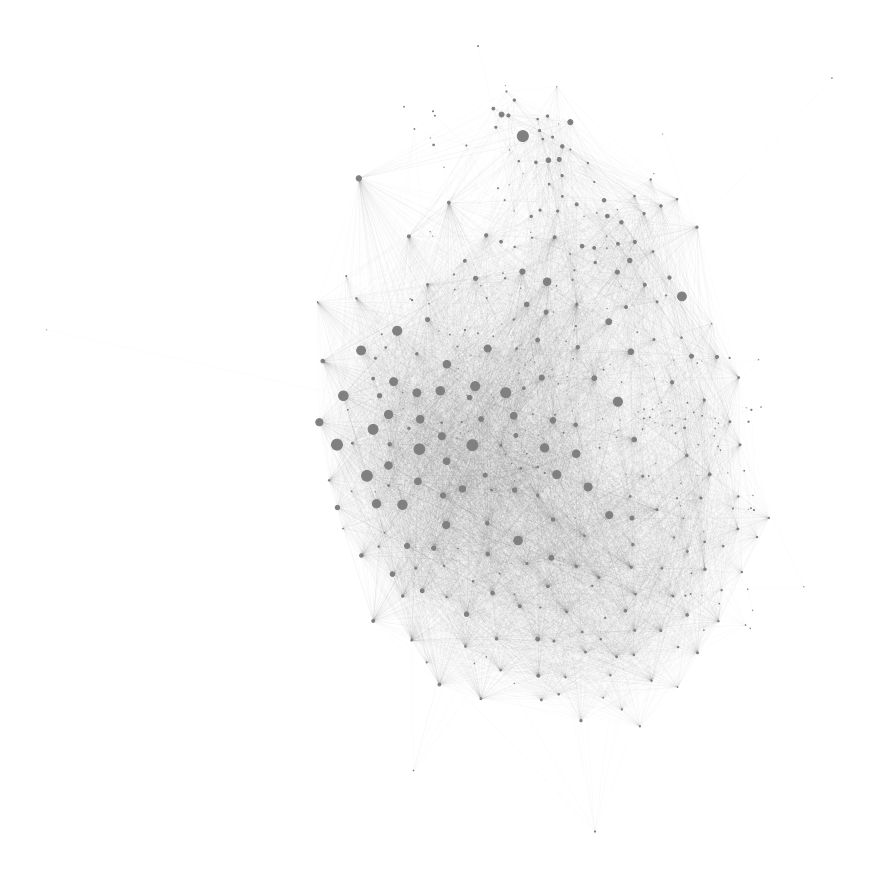

In [36]:
plt.figure(figsize = (12, 12))
plt.tight_layout()

nx.draw(G, pos = positions, node_size = node_sizes, node_color = 'grey', width = 0.01)

* Interactive network

In [6]:
import plotly.graph_objs as go

hotelnames = list(G.nodes())

NameError: name 'G' is not defined

In [7]:
lat = list(business_df[business_df.business_id.isin(hotelnames)].latitude)
lon = list(business_df[business_df.business_id.isin(hotelnames)].longitude)
position = dict(zip(hotelnames, np.array(list(zip(lat, lon)))))
node_size = list(business_df[business_df.business_id.isin(hotelnames)].review_count*0.005)

NameError: name 'business_df' is not defined

In [9]:
for n,p in position.items():
    G.nodes[n]['pos']=p
    
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.01, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='Blackbody',
        reversescale=True,
        color=[],
        size=node_size,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

NameError: name 'position' is not defined

In [559]:
node_adjacencies = []
node_text = []
node_names = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# of connections: '+str(len(adjacencies[1])))

for node in G.adjacency():
    node_names.append(node[0])

In [560]:
node_trace.marker.color = node_adjacencies
node_trace.text = list(zip(node_names,node_text))

In [561]:
### create graph 
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                plot_bgcolor='white',
                title='Hotels network',
                titlefont_size=30,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=60),
                annotations=[ dict(
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

Looks like a Barabasi-Albert network, with some central hubs (with large size, because of their lots of reviews), which get connected together with many smaller nodes (with less reviews).

This clearly shows that there are some hotels which are very popular and attract most clients, and the black mass of edges inside the center shows that these hotels are each other's strong competitors, since the same clients have consequently gone to these hotels, thereby linking them together in our network.

The network edges are weight-adjusted depending on their frequency, with higher thickness/weight meaning higher frequency.

In [535]:
degree_list = [x[1] for x in list(G.degree())]

max_degree = max(degree_list)
min_degree = min(degree_list)

print('The maximum degree in our network is:', max_degree)
print('The minimum degree in our network is:', min_degree)

The maximum degree in our network is: 160
The minimum degree in our network is: 1


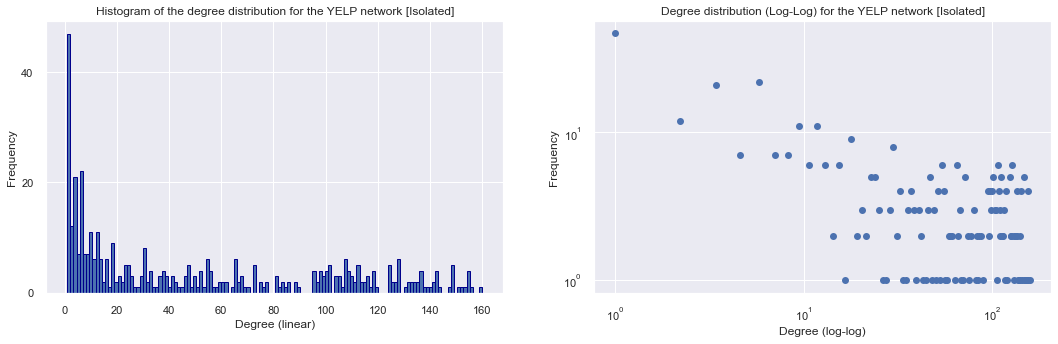

In [536]:
hist, bins = np.histogram(degree_list, bins = len(set(degree_list)))

fig, axs = plt.subplots(1, 2, figsize = (18, 5))

counts = axs[0].hist(degree_list, bins = bins, ec = "darkblue")
axs[0].set_title('Histogram of the degree distribution for the YELP network [Isolated]')
axs[0].set_yticks(ticks = range(0, max(hist) + 1, 20));
axs[0].set_xlabel('Degree (linear)')
axs[0].set_ylabel('Frequency')

axs[1].loglog(bins[:-1], hist, 'bo', markersize = 7)
axs[1].set_title('Degree distribution (Log-Log) for the YELP network [Isolated]')
axs[1].set_xlabel('Degree (log-log)')
axs[1].set_ylabel('Frequency');

---
<a id='3.2.'></a>
### 3.2 Community detection

* Louvain algorithm

In [537]:
import community

# Find the best community partition for the DC universe
partition_hotels = community.best_partition(G, random_state = 3)

print("The Louvain algorithm has found", len(set(partition_hotels.values())), "communities for hotel landscape in Las Vegas.")

The Louvain algorithm has found 4 communities for hotel landscape in Las Vegas.


In [538]:
# For this visualization, let's create a modifiable copy of the DC subgraph
viz_hotels_graph = G.copy()

# Split the nodes by their community number
dict_communities = {}

for community_nr in range(0, max(partition_hotels.values()) + 1):
    dict_communities[community_nr] = [name for name, comm in partition_hotels.items() if comm == community_nr]

In [41]:
# Create instance for FA2
forceatlas2 = FA2(scalingRatio = 100, gravity = 100, outboundAttractionDistribution = True)

positions = forceatlas2.forceatlas2_networkx_layout(viz_hotels_graph, pos = None, iterations = 1000)

100%|██████████| 1000/1000 [00:03<00:00, 317.44it/s]

BarnesHut Approximation  took  0.86  seconds
Repulsion forces  took  1.86  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.11  seconds


In [42]:
character_color_dict = {}
community_color_list = ['#00FA9A', '#0000FF', '#228B22', '#6495ED', '#FF1493', '#FFD700', '#4169E1', '#FF0000', '#7FFF00', '#808080', '#3DFA23', '#ABB351']

for community_nr, character_name_list in dict_communities.items():
    
    # For every node in this community, we assign them a previously-computed color
    for character_name in character_name_list:
        character_color_dict[character_name] = community_color_list[community_nr]
                
        
# The node colors in the DICT are not in the same order as the nodes in the graph, therefore we need to create a separate list to deal with that
node_color_list = []
# At the same time, we will create a list of node sizes by looking directly at the degree of each individual node (within the undirected Comics network)
node_size_list = []

for node in viz_hotels_graph:
    
    # Append the appropriate color to a node
    node_color_list.append(character_color_dict[node])

    # Append the appropriate size to a node
    node_size_list.append(viz_hotels_graph.degree(node) * 0.6)

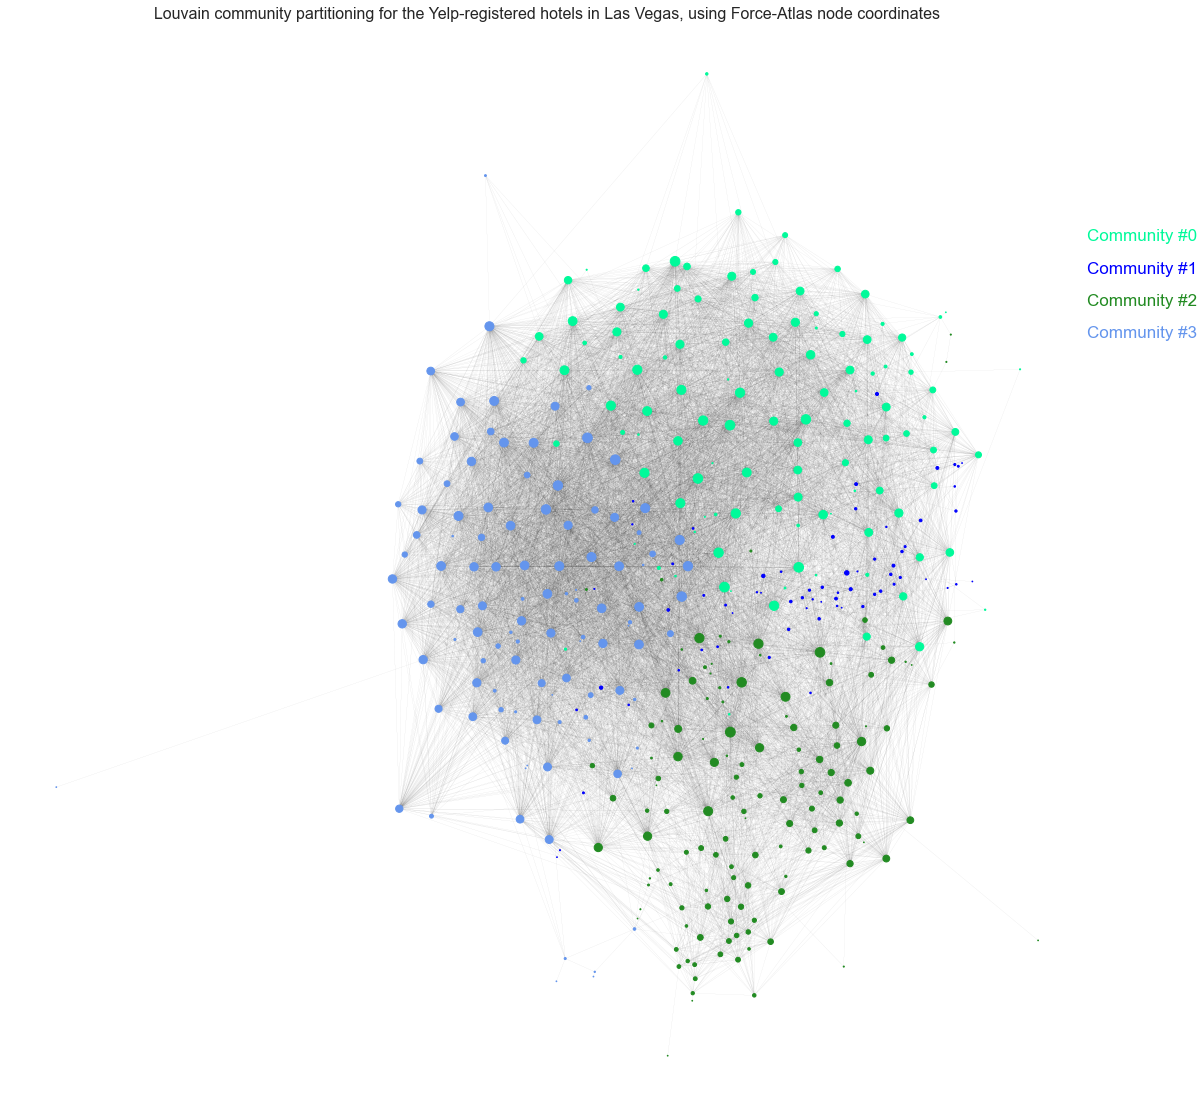

In [43]:
plt.figure(figsize = (15, 15))

nx.draw(viz_hotels_graph, pos = positions, node_size = node_size_list, node_color = node_color_list, width = 0.025)

y = 0.80 # This is the starting Y, for the figure text
# Indicating community colors
for i in dict_communities.keys():
    plt.figtext(1, y, str('Community #' + str(i)), size = 17, color = community_color_list[i])
    y = y - 0.03

plt.title("Louvain community partitioning for the Yelp-registered hotels in Las Vegas, using Force-Atlas node coordinates", fontsize = 16);

* Interactive network

In [4]:
for n,p in position.items():
    G.nodes[n]['pos']=p
    
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.01, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Blackbody',
        reversescale=True,
        color=[],
        size=nodesz,
        colorbar=dict(
            thickness=15,
            title='Communities',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

NameError: name 'position' is not defined

In [5]:
node_group = []
node_names = []

for node in G.adjacency():
    node_names.append(node[0])
    node_group.append('Community: '+ str([k for k,v in dict_communities.items() if node[0] in v]))

NameError: name 'G' is not defined

In [547]:
node_trace.marker.color = node_color_list
node_trace.text = list(zip(node_names,node_group))

In [548]:
### create graph 
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                plot_bgcolor='white',
                title='Hotel communities',
                titlefont_size=30,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=60),
                #annotations=[ dict(
                    #text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                    #showarrow=False,
                    #xref="paper", yref="paper",
                    #x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

---
<a id='3.2.'></a>
### Community wordclouds

* Calculate TF, IDF, TF-IDF over community

In [44]:
# Convert reviews of each community into one text for analysis
community_reviews = reviews(df = business_review_df, mode = 'community', dict_communities = dict_communities)

In [45]:
# Calculate term frequency of each community
community_term_frequency = tf(reviews = community_reviews, tf_method = 'term_frequency')

In [46]:
# Calculate inverse document frequency of each community
community_inverse_document_frequency  =  idf(reviews = community_reviews, term_frequency = community_term_frequency, idf_method = 'idf')

In [47]:
# Calculate TF-IDF score of each community
community_tf_idf = tf_idf(term_frequency = community_term_frequency,  inverse_document_frequency = community_inverse_document_frequency)

In [48]:
# Function for converting the word dictionary into a string
def dict_to_string(word_dict, amplify=True):
    
    total_string = ''
    
    for word in word_dict:
        
        # If the tf-idf scores of words are too small, we times the original score by 1e8 for differentiating them better
        if amplify==True:
            repeat_nr = math.ceil(word_dict[word] * (10**8))
        
        else:
            repeat_nr = math.ceil(word_dict[word])
        
        # Create a string of one term (occuring, in a proportional manner, according to the TF-TR scores)
        string = ''.join([word + ' ' for count in range(repeat_nr)])
        
        # Concatenate the current elements to the total string
        total_string += string
        
    return total_string

* Convert words into string for word clouds

In [49]:
text = {}
wordclouds = []
for comm in community_tf_idf.keys():
    text[comm] = dict_to_string(community_tf_idf[comm], False)

* Generate interactive word clouds

In [286]:
def create_wordcloud(community, frame, maximum, atitle):
    if community == 0:
        mk = imageio.imread('./club.jpg')
    if community == 1:
        mk = imageio.imread('./diamond.png')
    if community == 2:
        mk = imageio.imread('./spade.jpg')
    if community == 3:
        mk = imageio.imread('./heart.jpg')
   
    wordcloud = WordCloud(max_font_size = 70, 
                                       max_words = maximum, 
                                       background_color = 'white',
                                       collocations = False,
                                       mask = mk).generate(text[community])
    image_colors = ImageColorGenerator(mk)
    
    plt.figure
    plt.style.use('seaborn')
    plt.figure(figsize=[15, 15])
    plt.title('community '+str(community), fontsize = 20)
    plt.imshow(wordcloud.recolor(color_func = image_colors), interpolation = 'bilinear')
    plt.axis('off')

In [287]:
w = interact(create_wordcloud, frame=fixed(text), community=[0, 1, 2, 3], maximum=[50,100,300], atitle=fixed(''))


interactive(children=(Dropdown(description='community', options=(0, 1, 2, 3), value=0), Dropdown(description='…

<a id='4.'></a>
## Part 4: Sentiment Analysis

In [113]:
afinn = pd.read_csv('./AFINN-165.txt', sep="\t", skiprows = 2, header = None).rename(columns = {0: 'word', 1: 'sentiment_score'})
afinn.head(5)

word  sentiment_score
0    abandons               -2
1    abducted               -2
2   abduction               -2
3  abductions               -2
4       abhor               -3

In [114]:
# Create a dictionary containing the avg happiness score of each word from LabMT
afinn_sentiment_score = dict(zip(afinn['word'], afinn['sentiment_score']))

* Calculate and store sentiment score for each business or community

In [297]:
def sentiment_score(reviews, remove_stopwords=True, sentiment_score = afinn_sentiment_score):
    # Create a dictionary for storing sentiment score of each community or business
    sentiment = {}
    
    # Get the set of  stopwords
    stop_words = set(stopwords.words('english'))  
    
    # For each community or business
    for comm in reviews.keys():
        
        # Tokenize the original review only extracting words and set words to lowercase
        words = word_tokenize(re.sub('[^a-zA-Z\s]', ' ', reviews[comm]).lower())
          
        # Remove stopwords
        if remove_stopwords:
            words = [word for word in words if word not in stop_words]
            
        # Create the sentiment list of each word in the word list which also has a sentiment score in LabMT, of each community or business
        sentiments = [sentiment_score[word] for word in words if word in sentiment_score.keys()]
        # Compute the average sentiment score and round it
        avg_sentiment = round(np.mean(sentiments), 3)
        #  Store avg sentiment for each community or business
        sentiment[comm] = avg_sentiment
    
    return sentiment

* Business sentiment score

In [174]:
business_sentiment = sentiment_score(business_reviews)

In [338]:
# Add sentiment score to business_df
business_df['sentiment'] = business_df['business_id'].map(business_sentiment)  

In [175]:
business_sentiment_value_sorted = sorted([v for k, v in business_sentiment.items()], reverse = True)

In [10]:
hist, bin_edge = np.histogram(business_sentiment_value_sorted, bins=100)
plt.plot(bin_edge, np.insert(hist, 0, hist[0]), drawstyle='steps')
plt.xlabel('Bins')
plt.ylabel('Count')
plt.title('Sentiment histogram of hotels in Las Vegas')
plt.ylabel('Number of hotels')
plt.xlabel('Sentiment score')
plt.show()

NameError: name 'np' is not defined

In [119]:
business_sentiment_sorted = sorted([v for k, v in business_sentiment.items()], reverse = True)

* What are the 10 hotels with most positive reviews?

In [120]:
i = 1
# Sort the sentiment score dictionary of businesses by value from highest to lowest
for key, value in sorted(business_sentiment.items(), key = lambda x:x[1], reverse = True)[:10]:
    print('#{} {}: {}'.format(i, business_df[business_df.business_id == key].name.values[0], value))
    i += 1

#1 Roberta's Steakhouse: 2.47059
#2 Fortunes: 2.31034
#3 Team Kaizen: 2.30303
#4 Sands Hotel: 2.25
#5 Jennifer Romas' Sexxy: 2.11669
#6 Lip Smacking Foodie Tours: 2.09353
#7 Star Motel: 2.06667
#8 Plaza Offices: 2.05263
#9 Venetian Casino Grazie Club Gold Room: 2.03333
#10 Las Vegas Strip Trips: 1.99078


* What are the 10 hotels with most negative reviews?

In [121]:
i = 1
# Sort the sentiment score dictionary of businesses by value from highest to lowest
for key, value in sorted(business_sentiment.items(), key = lambda x:x[1], reverse = True)[-10:]:
    print('#{} {}: {}'.format(i, business_df[business_df.business_id == key].name.values[0], value))
    i += 1

#1 Super 8 Motel: -0.68182
#2 Lamplighter Motel: -0.68182
#3 Siegel Suites Bonanza: -0.69697
#4 Holiday House Holiday Motel: -0.71154
#5 Desert Star Motel: -0.90411
#6 Holiday Motel: -0.91667
#7 Las Vegas Villa: -0.95745
#8 Siegel Suites: -1.09091
#9 Umpire: -1.22222
#10 Exotic Escapes: -1.38095


* Community sentiment score

In [105]:
community_sentiment = sentiment_score(community_reviews)

In [106]:
community_sentiment

{0: 0.77612, 1: 0.53406, 2: 1.03911, 3: 1.06779}

---
### Temporal sentiment map

* Create quarter and hour function to split datetime into temporal chunks

In [220]:
# Convert date object to datetime type
business_review_df.date = pd.to_datetime(business_review_df.date)

In [255]:
# Function for split date into quarters
def quarter(df):
    # Q1
    if (df.month >= 1) & (df.month < 4):
        return 'Q1'
    # Q2
    if (df.month >= 4) & (df.month < 7):
        return 'Q2'
    # Q3
    if (df.month >= 7) & (df.month < 10):
        return 'Q3'
    # Q4
    if (df.month >= 10) & (df.month <= 12):
        return 'Q4'

In [265]:
# Function for split date into quarters
def hour(df):
    # Midnight
    if (df.hour >= 0) & (df.hour < 6):
        return 'Night'
    # Morning
    if (df.hour >= 6) & (df.hour < 11):
        return 'Morning'
    # Noon
    if (df.hour >= 11) & (df.hour < 14):
        return 'Noon'   
    # Afternoon
    if (df.hour >= 14) & (df.hour < 18):
        return 'Afternoon'  
    # Night
    if (df.hour >= 18) & (df.hour <= 23):
        return 'Evening'      

In [268]:
business_review_df['quarter'] = business_review_df.date.apply(quarter)
business_review_df['day_time'] = business_review_df.date.apply(hour)

* Set up temporal date frame for visualization

In [356]:
def temporal_sentiment(business_review_df, business_df, mode):
    if mode == 'quarter':
        # For each quarter
        for q in business_review_df.quarter.unique():
            #  Filter the business_review_df according to specific quarter
            business_review_quarter_df = business_review_df[business_review_df.quarter == q]
            #  Combine reviews of each business
            business_reviews_quarter = reviews(df = business_review_quarter_df, mode = 'business')
            # Compute the sentiment score dictionary of each business in a quarter
            business_sentiment_quarter = sentiment_score(business_reviews_quarter)
            #  Add sentiment dictionary of each quarter as a column to business_df
            business_df['sentiment_'+q] = business_df['business_id'].map(business_sentiment_quarter)     
            business_df['sentiment_'+q] = business_df['sentiment_'+q].fillna(0)
    
    if mode == 'day_time':
        for time in business_review_df.day_time.unique():
             #  Filter the business_review_df according to specific day time
            business_review_hour_df = business_review_df[business_review_df.day_time == time]
            #  Combine reviews of each business
            business_reviews_hour = reviews(df = business_review_hour_df, mode = 'business')
            # Compute the sentiment score dictionary of each business within a certain day time
            business_sentiment_hour = sentiment_score(business_reviews_hour)
            #  Add sentiment dictionary of each day time as a column to business_df
            business_df['sentiment_'+time] = business_df['business_id'].map(business_sentiment_hour)
            business_df['sentiment_'+time] = business_df['sentiment_'+time].fillna(0)
    
    return  business_df

In [357]:
business_df = temporal_sentiment(business_review_df = business_review_df, business_df = business_df, mode = 'quarter')
business_df = temporal_sentiment(business_review_df = business_review_df, business_df = business_df, mode = 'day_time')

/Users/yingrui/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/Users/yingrui/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars



* Visualize geomap

> Geomap of overall sentiment

In [428]:
fig = px.scatter_mapbox(business_df, 
                                   lat = 'latitude',
                                   lon = 'longitude',
                                   hover_name = 'name', 
                                   hover_data = ['top_keywords'],
                                   color = 'sentimen', 
                                   color_continuous_scale = 'balance', 
                                   size = 'review_count', 
                                   zoom=10, 
                                   height=300)
fig.update_layout(mapbox_style='carto-positron')

fig.update_layout(margin={'r': 0, 't': 0, 'l': 0, 'b': 0})
fig.show()

> Geomap of sentiment in different quarter

In [490]:
fig_quarter = px.scatter_mapbox(business_df, 
                                    lat = 'latitude',
                                    lon = 'longitude',
                                    hover_name = 'name', 
                                    hover_data = ['top_keywords'],
                                    color =  'sentiment_Q1',
                                    color_continuous_scale = 'balance', 
                                    size = 'review_count', 
                                    zoom = 10, 
                                    height = 300)

fig_quarter.add_trace(px.scatter_mapbox(business_df,
                                              lat = 'latitude',
                                              lon = 'longitude',
                                              hover_name = 'name', 
                                              hover_data = ['top_keywords'],
                                              color =  'sentiment_Q2',
                                              color_continuous_scale = 'balance', 
                                              size = 'review_count', 
                                              zoom = 10, 
                                              height = 300).data[0])
fig_quarter.add_trace(px.scatter_mapbox(business_df,
                                              lat = 'latitude',
                                              lon = 'longitude',
                                              hover_name = 'name', 
                                              hover_data = ['top_keywords'],
                                              color =  'sentiment_Q3',
                                              color_continuous_scale = 'balance', 
                                              size = 'review_count', 
                                              zoom = 10, 
                                              height = 300).data[0])
fig_quarter.add_trace(px.scatter_mapbox(business_df,
                                              lat = 'latitude',
                                              lon = 'longitude',
                                              hover_name = 'name', 
                                              hover_data = ['top_keywords'],
                                              color =  'sentiment_Q4',
                                              color_continuous_scale = 'balance', 
                                              size = 'review_count', 
                                              zoom = 10, 
                                              height = 300).data[0])

updatemenus = [dict(type = "buttons", 
                             direction = "down",
                             buttons = 
                             list([dict(args=[{'visible': [True, False, False, False]}, 'type'],
                                         label = "Q1", 
                                         method="update"),

                                   dict(args=[{'visible': [False, True, False, False]}, 'type'],
                                         label = "Q2", 
                                         method="update"),
                                   
                                   dict(args=[{'visible': [False, False, True, False]}, 'type'],
                                         label = "Q3", 
                                         method="update"),
                                   
                                   dict(args=[{'visible': [False, False, False, True]}, 'type'],
                                         label = "Q4", 
                                         method="update")
                                  ])
                       )]


fig_quarter.update_layout(updatemenus = updatemenus,
                         legend_title_text='Sentiment score over year quarters')
fig_quarter.update_layout(mapbox_style='carto-positron')
fig_quarter.update_layout(margin={'r': 0, 't': 0, 'l': 0, 'b': 0})
fig_quarter.show()

In [493]:
fig_day = px.scatter_mapbox(business_df, 
                                    lat = 'latitude',
                                    lon = 'longitude',
                                    hover_name = 'name', 
                                    hover_data = ['top_keywords'],
                                    color =  'sentiment_Morning',
                                    color_continuous_scale = 'balance', 
                                    size = 'review_count', 
                                    zoom = 10, 
                                    height = 300)

fig_day.add_trace(px.scatter_mapbox(business_df,
                                              lat = 'latitude',
                                              lon = 'longitude',
                                              hover_name = 'name', 
                                              hover_data = ['top_keywords'],
                                              color =  'sentiment_Noon',
                                              color_continuous_scale = 'balance', 
                                              size = 'review_count', 
                                              zoom = 10, 
                                              height = 300).data[0])
fig_day.add_trace(px.scatter_mapbox(business_df,
                                              lat = 'latitude',
                                              lon = 'longitude',
                                              hover_name = 'name', 
                                              hover_data = ['top_keywords'],
                                              color =  'sentiment_Afternoon',
                                              color_continuous_scale = 'balance', 
                                              size = 'review_count', 
                                              zoom = 10, 
                                              height = 300).data[0])
fig_day.add_trace(px.scatter_mapbox(business_df,
                                              lat = 'latitude',
                                              lon = 'longitude',
                                              hover_name = 'name', 
                                              hover_data = ['top_keywords'],
                                              color =  'sentiment_Night',
                                              color_continuous_scale = 'balance', 
                                              size = 'review_count', 
                                              zoom = 10, 
                                              height = 300).data[0])
fig_day.add_trace(px.scatter_mapbox(business_df,
                                              lat = 'latitude',
                                              lon = 'longitude',
                                              hover_name = 'name', 
                                              hover_data = ['top_keywords'],
                                              color =  'sentiment_Midnight',
                                              color_continuous_scale = 'balance', 
                                              size = 'review_count', 
                                              zoom = 10, 
                                              height = 300).data[0])

updatemenus = [dict(type = "buttons", 
                             direction = "down",
                             buttons = 
                             list([dict(args=[{'visible': [True, False, False, False, False]}, 'type'],
                                         label = "Morning", 
                                         method="update"),

                                   dict(args=[{'visible': [False, True, False, False, False]}, 'type'],
                                         label = "Noon", 
                                         method="update"),
                                   
                                   dict(args=[{'visible': [False, False, True, False, False]}, 'type'],
                                         label = "Afternoon", 
                                         method="update"),
                                   
                                   dict(args=[{'visible': [False, False, False, True, False]}, 'type'],
                                         label = "Evening", 
                                         method="update"),
                                   
                                   dict(args=[{'visible': [False, False, False, False, True]}, 'type'],
                                         label = "Night", 
                                         method="update")
                                  ])
                       )]


fig_day.update_layout(updatemenus = updatemenus,
                         legend_title_text='')
fig_day.update_layout(mapbox_style='carto-positron')
fig_day.update_layout(margin={'r': 0, 't': 0, 'l': 0, 'b': 0})
fig_day.show()

> Geomap of sentiment of different parts of day

---
### <font color='red'>Topic detection (LDA)

In [276]:
# import gensim
# from gensim import corpora, models

In [320]:
# business_reviews_df = pd.DataFrame(list(business_reviews.items()), columns=['business_id', 'review'])

/Users/yingrui/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [321]:
# reviews_text = business_reviews_df.review.apply(tokenize_text)

/Users/yingrui/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [322]:
# dictionary = corpora.Dictionary(reviews_text)

/Users/yingrui/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [323]:
# corpus = [dictionary.doc2bow(review) for review in reviews_text]

/Users/yingrui/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [324]:
# lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=4, id2word = dictionary, passes=20)

/Users/yingrui/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [325]:
# lda_model.print_topics(num_topics=4, num_words=20)

/Users/yingrui/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.028*"great" + 0.027*"nice" + 0.022*"good" + 0.015*"clean" + 0.015*"free" + 0.010*"next" + 0.009*"new" + 0.009*"little" + 0.009*"small" + 0.009*"bad" + 0.008*"much" + 0.008*"first" + 0.008*"big" + 0.008*"front" + 0.007*"comfortable" + 0.007*"last" + 0.007*"full" + 0.007*"many" + 0.007*"strip" + 0.007*"sure"'),
 (1,
  '0.033*"great" + 0.027*"nice" + 0.018*"good" + 0.013*"beautiful" + 0.011*"best" + 0.009*"clean" + 0.009*"venetian" + 0.009*"next" + 0.009*"little" + 0.009*"huge" + 0.009*"free" + 0.008*"many" + 0.008*"first" + 0.008*"much" + 0.008*"big" + 0.008*"suite" + 0.007*"new" + 0.007*"comfortable" + 0.007*"sure" + 0.007*"large"'),
 (2,
  '0.026*"good" + 0.022*"great" + 0.020*"nice" + 0.015*"clean" + 0.014*"old" + 0.013*"free" + 0.013*"bad" + 0.011*"new" + 0.010*"next" + 0.009*"little" + 0.009*"much" + 0.009*"last" + 0.009*"first" + 0.008*"cheap" + 0.007*"big" + 0.007*"small" + 0.007*"front" + 0.007*"sure" + 0.007*"many" + 0.006*"best"'),
 (3,
  '0.047*"good" + 0.031*"great"

In [326]:
# import pyLDAvis
# import pyLDAvis.gensim
# vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary)
# pyLDAvis.enable_notebook()
# pyLDAvis.display(vis)

/Users/yingrui/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
